In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import geopandas as gpd

# Read the CSV into a DataFrame
criminal_data_raw = pd.read_csv('C:\\Users\\12630\\Documents\\WeChat Files\\wxid_vxpw0gm7m8lp22\\FileStorage\\File\\2023-12\\Assault_Open_Data.csv')

criminal_data_raw.head()

criminal_data_sorted = criminal_data_raw[[ 'OCC_DOW', 'OCC_DATE','OCC_HOUR', 'LOCATION_TYPE','PREMISES_TYPE',
                                        'OFFENCE','NEIGHBOURHOOD_140','LONG_WGS84','LAT_WGS84']]

criminal_data_subway = criminal_data_sorted[criminal_data_sorted['LOCATION_TYPE'].str.contains('Ttc Subway Station', case=False, na=False)]
criminal_data_subway.head(1)

,OCC_DOW,OCC_DATE,OCC_HOUR,LOCATION_TYPE,PREMISES_TYPE,OFFENCE,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,Wednesday,2014/01/01 05:00:00+00,0,Ttc Subway Station,Transit,Assault,Rosedale-Moore Park (98),-79.384206,43.670798


In [6]:
from pyproj import Proj, Transformer
from shapely.geometry import Point

stations_gdf = gpd.read_file(r'C:\Users\12630\Documents\WeChat Files\wxid_vxpw0gm7m8lp22\FileStorage\File\2023-12\subway_stations.shp')

# Display the first few rows of the GeoDataFrame
stations_gdf.head()

utm_zone = 17
is_south = False

# Create a Transformer object for UTM to WGS84 coordinate transformation
transformer = Transformer.from_proj(
    Proj(proj='utm', zone=utm_zone, ellps='WGS84', south=is_south),
    Proj(proj='latlong', datum='WGS84')
)

# Function to convert UTM to Lat/Lon
def utm_to_latlon(point):
    if point and isinstance(point, Point):
        lon, lat = transformer.transform(point.x, point.y)
        return lat, lon
    else:
        return None, None

# Apply the function to the 'geometry' column
stations_gdf[['Latitude', 'Longitude']] = stations_gdf['geometry'].apply(utm_to_latlon).apply(pd.Series)

# Display the DataFrame
print(stations_gdf.head(1))

   STATION            LINE PLATFORM_L  AVG_PASSEN LINE2 PLATFORM_1 SUBWAY_TRA  \
0  Kipling  Bloor-Danforth          1       53640  None       None      False   

                ADDRESS  Opened                        geometry   Latitude  \
0  5247 Dundas St. West    1980  POINT (618101.613 4832636.300)  43.637345   

   Longitude  
0 -79.535833  


In [7]:
# Map each station incident to the nearest station
def pyth(l_x, l_y, r_x, r_y):
    result = (r_x - l_x) ** 2 + (r_y - l_y) ** 2
    return result

closest_stations = []
for incident in range(criminal_data_subway.shape[0]):
    closest_distance = 999
    closest_id = 0
    for station in range(stations_gdf.shape[0]):
        pyth_result = pyth(criminal_data_subway.iloc[incident]["LAT_WGS84"], 
                            criminal_data_subway.iloc[incident]["LONG_WGS84"],
                            stations_gdf.loc[station, "Latitude"], 
                            stations_gdf.loc[station, "Longitude"]) 
        if pyth_result < closest_distance:
            closest_id = station
            closest_distance = pyth_result
    closest_stations.append(closest_id)
            

In [8]:
criminal_data_subway["station_id"] = closest_stations
criminal_data_subway = criminal_data_subway[["OCC_DATE", "OCC_HOUR", "OCC_DOW", "station_id"]]

C:\Users\12630\AppData\Local\Temp\ipykernel_24284\2502563516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  criminal_data_subway["station_id"] = closest_stations


In [9]:
criminal_data_subway.groupby("station_id").count()
daily_criminal_data = criminal_data_subway.drop(columns=["OCC_HOUR"])
daily_criminal_data["month"] = pd.to_datetime(daily_criminal_data["OCC_DATE"]).dt.strftime('%m')
daily_criminal_data.head()

,OCC_DATE,OCC_DOW,station_id,month
0,2014/01/01 05:00:00+00,Wednesday,17,01
43,2014/01/01 05:00:00+00,Wednesday,13,01
170,2014/01/05 05:00:00+00,Sunday,37,01
203,2014/01/05 05:00:00+00,Sunday,37,01
205,2014/01/05 05:00:00+00,Sunday,10,01


In [10]:
summary_by_day = (daily_criminal_data.groupby("month").count()) / 10

Text(0.5, 1.0, 'Number of Assaults per month')

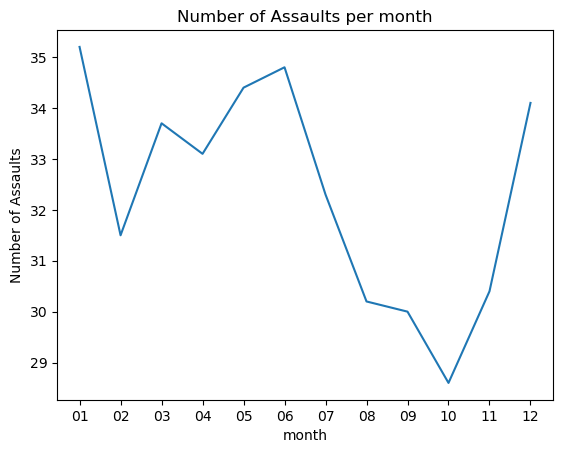

In [12]:
sns.lineplot(summary_by_day, x="month", y="station_id")
plt.ylabel("Number of Assaults")
plt.title("Number of Assaults per month")

In [14]:
hourly_crime_rate = criminal_data_subway[["OCC_HOUR", "station_id"]].groupby("OCC_HOUR").count()

Text(0.5, 1.0, 'Number of Assaults per Hour over 10-Year')

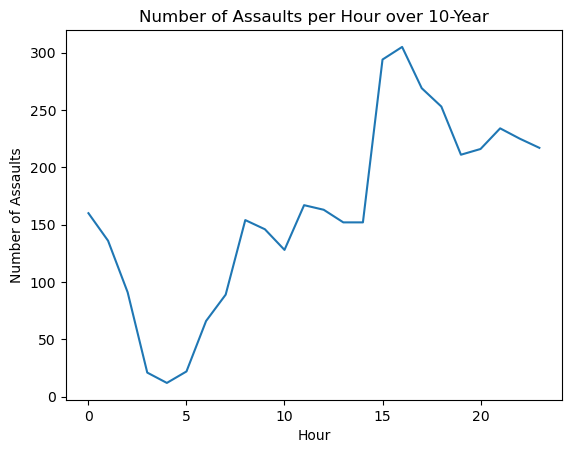

In [16]:
sns.lineplot(hourly_crime_rate, x="OCC_HOUR", y="station_id")
plt.xlabel("Hour")
plt.ylabel("Number of Assaults")
plt.title("Number of Assaults per Hour over 10-Year")

In [17]:
annual_crime_date = criminal_data_subway[["OCC_DATE", "station_id"]].groupby(pd.to_datetime(criminal_data_subway.OCC_DATE).dt.year).count()
annual_crime_date = annual_crime_date.loc[2014:2022]

Text(0.5, 1.0, 'Assaults by Year')

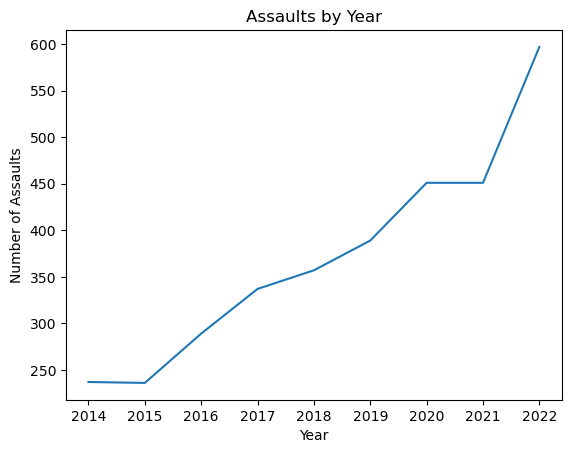

In [18]:
#plot the number of assaults based on year
sns.lineplot(annual_crime_date, x=annual_crime_date.index, y="station_id")
plt.xlabel("Year")
plt.ylabel("Number of Assaults")
plt.title("Assaults by Year")

In [168]:
# Get the top 3 stations with most assaults
criminal_data_subway_with_station_name = pd.merge(criminal_data_subway, stations_gdf[["STATION"]], 
                                                  left_on="station_id", right_on=stations_gdf.index)

In [176]:
criminal_data_subway_with_station_name.groupby("station_id").count().sort_values(ascending=False, by="STATION", inplace=True)
top_5_stations = criminal_data_subway_with_station_name.index[0:5]
top_stations = stations_gdf.loc[top_5_stations]

In [194]:
stations_count = criminal_data_subway_with_station_name.groupby("station_id").count().sort_values(ascending=False, by="STATION")
top_5_stations = stations_count.index[:5]
top_stations = stations_gdf.loc[top_5_stations]["STATION"]
top_station_counts = stations_count["STATION"].iloc[:5]

Text(0, 0.5, 'Number of assults')

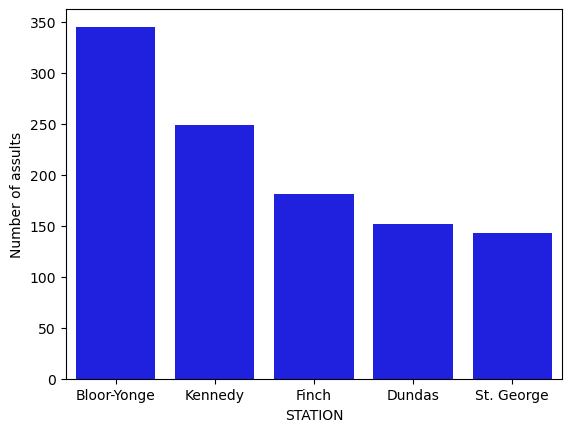

In [199]:
sns.barplot(x=top_stations, y=top_station_counts, color="blue")
plt.ylabel("Number of assults")

Text(0.5, 1.0, 'Crime at Bloor-Yonge')

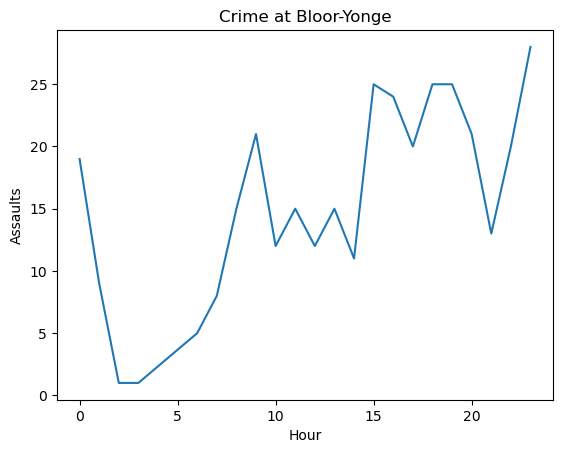

In [210]:
#plot the crime at Bloor-Yonge within a day
hourly_count = criminal_data_subway[criminal_data_subway.station_id == 17].groupby("OCC_HOUR").count()["station_id"]
sns.lineplot(hourly_count)
plt.xlabel("Hour")
plt.ylabel("Assaults")
plt.title("Hourly Crime at Bloor-Yonge")